In [9]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

3.6.8 (default, Apr 25 2019, 21:02:35) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]


In [10]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()

lumi = 137000 #in pb-1
path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p7/MC_Summer16/v10/sixie/'


In [11]:

fpath_bkg['bbbb10m'] = path + 'WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_displacedJetMuonNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v10_v1/190911_021111/0000/displacedJetMuon_ntupler_1.root'
fpath_bkg['bbbb1m'] = path + 'WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_displacedJetMuonNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v10_v1/190911_021122/0000/displacedJetMuon_ntupler_1.root'
fpath_bkg['bbbb0.1m'] = path + 'WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-100_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_displacedJetMuonNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v10_v1/190911_021133/0000/displacedJetMuon_ntupler_1.root'

xsec = {}
xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


xsec['WJetsToLNu'] = 61526.7

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'


legend['WJetsToLNu'] = 'WJetsToLNu'

NEvents = {}


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
#         tree_bkg[k] = root_dir['ntuples']['llp']
#         NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
    tree_bkg[k] = root_dir['ntuples']['llp']
#     NEvents[k] = root_dir['NEvents'][1]
#     tree[k] = root_dir['ntuples']
#     a = tree_bkg[k]["weight"].array()
  


bbbb10m /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p7/MC_Summer16/v10/sixie/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_displacedJetMuonNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v10_v1/190911_021111/0000/displacedJetMuon_ntupler_1.root
bbbb1m /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p7/MC_Summer16/v10/sixie/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_displacedJetMuonNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v10_v1/190911_021122/0000/displacedJetMuon_ntupler_1.root
bbbb0.1m /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p7/MC_Summer16/v10/sixie/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-100_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_displacedJetMuonNtupler_V1p7_MC_Summer16_RunIISummer1

In [12]:
trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
if wH:
    trigger_paths = [87,135] #PFMET120
else:
    trigger_paths = [177,362,87,135] #PFMET120

# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET


In [14]:
start_t = time.time()
nCsc = {}
nJets = {}
weight = {}
for k,T in tree_bkg.items():
#     weight[k] = T.array('weight')*lumi
    nCsc[k] =T.array('nCsc')    
    nJets[k] =T.array('nJets')

print(time.time()-start_t)

0.5716779232025146


# nCsc

# nCsc with different hit vetoing

In [17]:
# pdgId = 13
# if pdgId == 13:
#     trigger_paths = [135]
# else:
#     trigger_paths = [87]
gLLP_decay_vertex_x = {}
gLLP_decay_vertex_y = {}
gLLP_decay_vertex_z = {}
gLLP_decay_distance = {}
gLLP_r = {}
gLLP_eta = {}
nCsc = {}
for k,T in tree_bkg.items():
    
    hlt = T['HLTDecision'].array()
    print(len(hlt))
        # select only triggered events
#     sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
#     sel_ev= np.zeros(hlt[:,0].shape)
#     for tr in trigger_paths:
#         sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
    nCsc[k] = T.array('nCsc')
    gLLP_decay_vertex_x[k] = np.abs(T.array('gLLP_decay_vertex_x').flatten())
    gLLP_decay_vertex_y[k] = np.abs(T.array('gLLP_decay_vertex_y').flatten())
    gLLP_decay_vertex_z[k] = np.abs(T.array('gLLP_decay_vertex_z').flatten())
    gLLP_decay_distance[k] = np.sqrt(gLLP_decay_vertex_x[k]**2+gLLP_decay_vertex_y[k]**2+gLLP_decay_vertex_z[k]**2)
    gLLP_eta[k] = np.abs(T.array('gLLP_eta').flatten())
    gLLP_r[k] = np.sqrt(gLLP_decay_vertex_x[k]**2+gLLP_decay_vertex_y[k]**2)
    llp_sel = np.logical_and(gLLP_eta[k]<2.4, gLLP_eta[k]>0.9)
#     llp_sel = np.logical_and(llp_sel, gLLP_decay_vertex_z[k]<1100)
#     llp_sel = np.logical_and(llp_sel,gLLP_decay_vertex_z[k]>568)
    llp_sel = np.logical_and(llp_sel,gLLP_r[k]<695.5)
    gLLP_decay_vertex_z[k] = gLLP_decay_vertex_z[k][llp_sel]
    
    
    print(k,np.count_nonzero(llp_sel)/len(llp_sel))
    

24998
bbbb10m 0.21507720617649412
24997
bbbb1m 0.468156178741449
25000
bbbb0.1m 0.48126


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


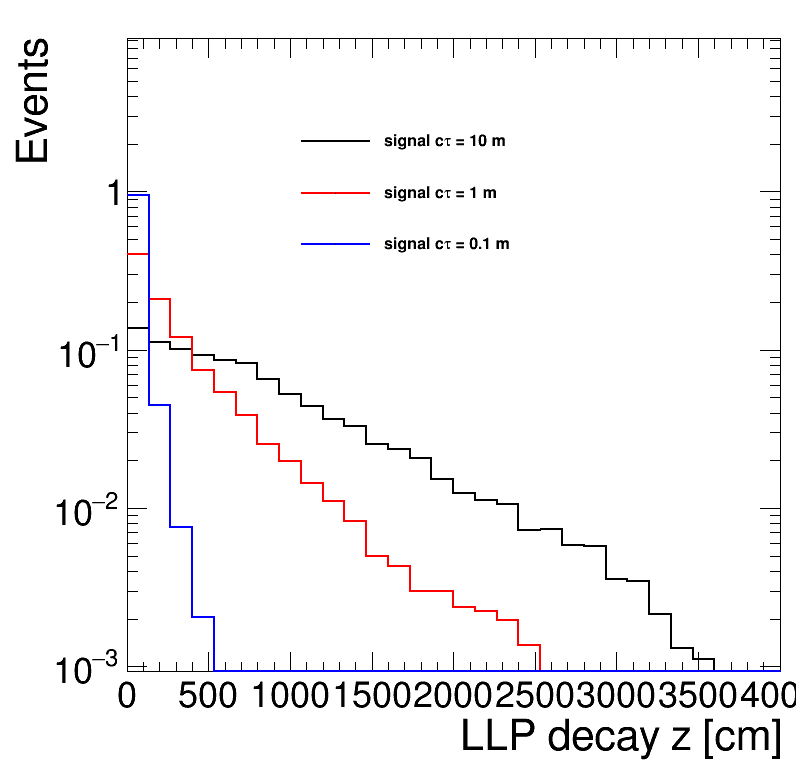

In [20]:
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.36,0.65,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
i = 0
for k,T in tree_bkg.items():
    h[k] = create_TH1D( gLLP_decay_vertex_z[k], axis_title=['LLP decay z [cm]', 'Events'], name=k, binning=[30,0,4000])
    h[k] = create_TH1D( nCsc[k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300])



#     h[k] = create_TH1D( gLLP_decay_distance[k], axis_title=['LLP decay distance [cm]', 'Events'], name=k, binning=[30,0,3000])
    h[k].SetLineColor(std_color_list[i])
    h[k].SetMaximum(100000)
    h[k].SetMinimum(10)


    leg.AddEntry(h[k],legend[k])
    h[k].DrawNormalized('same')
    i+=1
leg.Draw()
c.SetLogy()
c.Draw()

(163,) (163,)
nCsc_JetVetoCluster0p4 22691517.707704592
nCsc_JetVetoCluster0p4 0.004952257658569627
148
(151,) (151,)
nCsc_JetMuonVetoCluster0p4 26473437.325655356
nCsc_JetMuonVetoCluster0p4 0.005008433194045519
145
(139,) (139,)
nCsc_JetVetoCluster0p4_Me1112Veto 39710155.98848303
nCsc_JetVetoCluster0p4_Me1112Veto 0.004978254834402138
133
(138,) (138,)
nCsc_JetMuonVetoCluster0p4_Me1112Veto 79420311.97696605
nCsc_JetMuonVetoCluster0p4_Me1112Veto 0.0049358231163079466
132


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


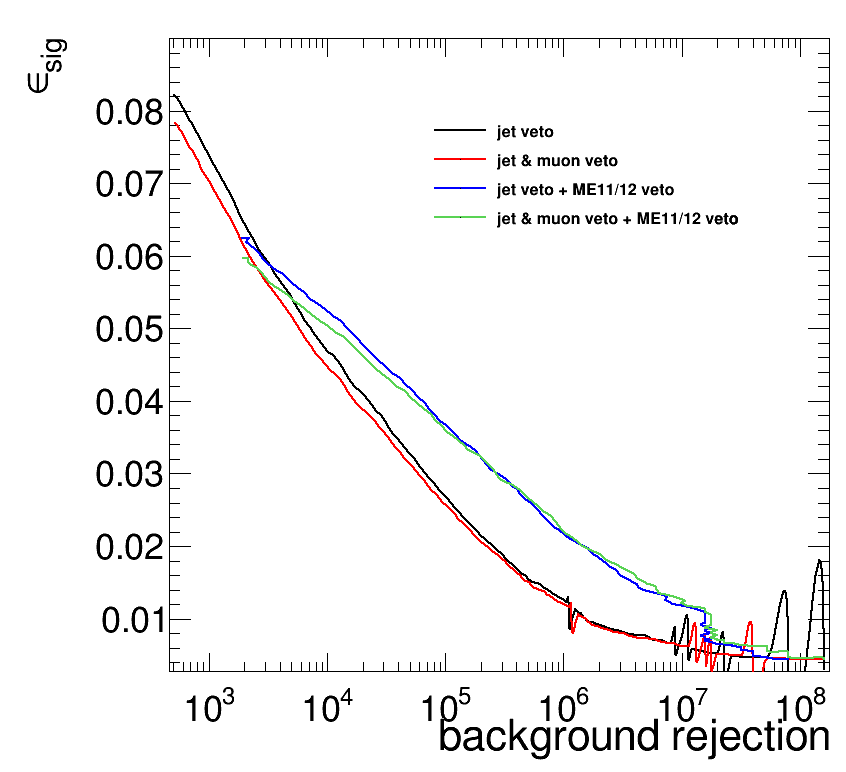

In [13]:
#ROC curve
c = rt.TCanvas('c','c', 850, 800)
leg = rt.TLegend(0.5,0.70,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}


# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# # moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']

# var = [nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['hit removal', 'cluster removal', 'hit removal + ME11/12 veto','cluster removal + ME11/12 veto']


# # with and without muon veto
var = [nCsc_JetVetoCluster0p4, nCsc_JetMuonVetoCluster0p4, 
       nCsc_JetVetoCluster0p4_Me1112Veto,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
name =['nCsc_JetVetoCluster0p4', 'nCsc_JetMuonVetoCluster0p4', 
       'nCsc_JetVetoCluster0p4_Me1112Veto','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
legend = ['jet veto', 'jet & muon veto', 'jet veto + ME11/12 veto','jet & muon veto + ME11/12 veto', ]


#calo vs. pf
# var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto,nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto', 'nCsc_caloJetMuonVetoCluster0p4_Me1112Veto', 'nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto']
# legend = ['pf jet & muon veto + ME11/12 veto','calo jet & muon veto + ME11/12 veto','pf & calo jet & muon veto + ME11/12 veto']

#calo jet
# var = [nCsc_caloJetVetoCluster0p4, nCsc_caloJetMuonVetoCluster0p4, 
#        nCsc_caloJetVetoCluster0p4_Me1112Veto,nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, ]
# name =['nCsc_caloJetVetoCluster0p4', 'nCsc_caloJetMuonVetoCluster0p4', 
#        'nCsc_caloJetVetoCluster0p4_Me1112Veto','nCsc_caloJetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['calojet veto', 'calojet & muon veto', 'calojet veto + ME11/12 veto','calojet & muon veto + ME11/12 veto', ]




# #compare sum vs. most populated cluster

# var = [nCsc0_JetMuonVetoCluster0p4, nCsc0_JetMuonVetoCluster0p4_Me1112Veto, 
#        nCsc_JetMuonVetoCluster0p4,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
# name = ['nCsc0_JetMuonVetoCluster0p4', 'nCsc0_JetMuonVetoCluster0p4_Me1112Veto', 
#        'nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['jet & muon veto, largest cluster', 'jet & muon veto + ME11/12 veto, largest cluster', 
# 'jet & muon veto, all clusters', 'jet & muon veto + ME11/12 veto, all clusters']



qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
thre = np.array(range(250))
for i in range(len(var)):
    eff = {}
    
    for k in tree_bkg.keys():
        v = var[i][k]
        eff[k] = []
        for th in thre:
#             if k == 'bbbb':
#                 eff[k].append(1.0*np.sum(weight[k][v>th])/np.sum(weight[k]))
#             else:
            eff[k].append(1.0*np.sum(weight[k][v>th])/(xsec[k]*lumi))
#         print(k,xsec[k]*lumi)

        eff[k] = np.array(eff[k])
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] <= 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] <= 0)]
#     print(eff[qcd_key])
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[name[i]] = create_TGraph(np.reciprocal(eff[qcd_key]),eff[sig_k],axis_title = ['background rejection','#epsilon_{sig}'])
#     gr[name[i]].SetLineColor(std_color_list[int(i/2)])
#     gr[name[i]].SetLineStyle(std_color_list[i%2])
    gr[name[i]].SetLineColor(std_color_list[i])
    gr[name[i]].SetLineStyle(std_color_list[0])
    gr[name[i]].SetLineWidth(2)
    gr[name[i]].GetYaxis().SetTitleOffset(1.5)

    gr[name[i]].GetYaxis().SetRangeUser(0,0.01)
#     gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[name[i]],legend[i])

    gr[name[i]].Draw('ac' if i==0 else 'c')
    c.SetLeftMargin(0.2)
    leg.Draw()
    value = 0.005 #target signal efficiency
    ind = np.abs(eff[sig_k]-value).argmin()
#     ind = 110
    print(name[i],1.0/eff[qcd_key][ind])
    print(name[i],eff[sig_k][ind])
    print(thre[ind])

c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')




# ROC curve for different cluster moment hit

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


(95,) (95,)
0 9343566.114937184
0 0.0050466837283288405
66
(95,) (95,)
10 10589374.930262143
10 0.0050466837283288405
66
(95,) (95,)
20 13236718.662827678
20 0.005082243537732183
65
(95,) (95,)
25 15884062.395393213
25 0.0050589370867796515
64
(74,) (74,)
30 15884062.395393213
30 0.004989307926903858
58
(73,) (73,)
35 22691517.707704592
35 0.005011123918925499
45
(72,) (72,)
40 5477262.894963177
40 0.0050218868184454205
32


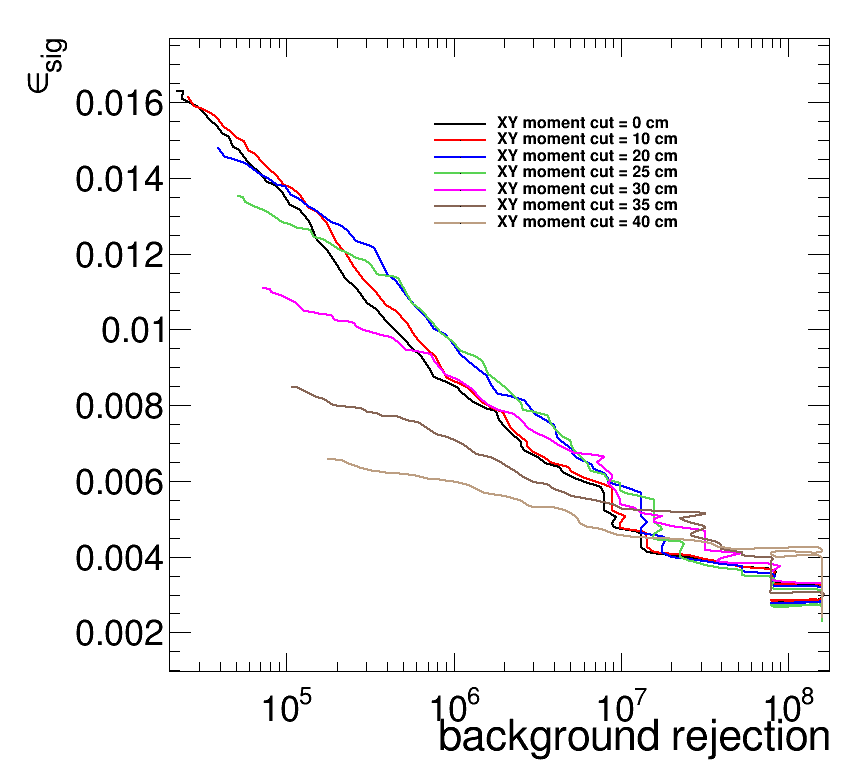

In [7]:
#ROC curve
c = rt.TCanvas('c','c', 850, 800)
leg = rt.TLegend(0.5,0.70,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}

cuts = [0,10,20,25,30,35,40]


qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
thre = np.array(range(250))
for i,cut in enumerate(cuts):
    eff = {}
    
    for k in tree_bkg.keys():
        cond = np.logical_not(np.isnan(cscClusterXYSpread[k]))
        cond = np.logical_and(cond, cscClusterXYSpread[k]>cut)
#         print(cscClusterXYSpread[k])
        v = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond]
#         print(v)
        w = weight[k][cond]
        eff[k] = []
        for th in thre:
#             if k == 'bbbb':
#                 eff[k].append(1.0*np.sum(weight[k][v>th])/np.sum(weight[k]))
#             else:
            eff[k].append(1.0*np.sum(w[v>th])/(xsec[k]*lumi))
#         print(k,xsec[k]*lumi)

        eff[k] = np.array(eff[k])
        
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] <= 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] <= 0)]
#     print(eff[sig_k],eff[qcd_key])
#     print(eff[qcd_key])
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[cut] = create_TGraph(np.reciprocal(eff[qcd_key]),eff[sig_k],axis_title = ['background rejection','#epsilon_{sig}'])
#     gr[name[i]].SetLineColor(std_color_list[int(i/2)])
#     gr[name[i]].SetLineStyle(std_color_list[i%2])
    gr[cut].SetLineColor(std_color_list[i])
    gr[cut].SetLineStyle(std_color_list[0])
    gr[cut].SetLineWidth(2)
    gr[cut].GetYaxis().SetTitleOffset(1.5)

    gr[cut].GetYaxis().SetRangeUser(0,0.01)
#     gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[cut],"XY moment cut = "+str(cut)+" cm")

    gr[cut].Draw('ac' if i==0 else 'c')
    c.SetLeftMargin(0.2)
    leg.Draw()
    value = 0.005 #target signal efficiency
    ind = np.abs(eff[sig_k]-value).argmin()
#     ind = 110
    print(cut,1.0/eff[qcd_key][ind])
    print(cut,eff[sig_k][ind])
    print(thre[ind])

c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')





# nCsc histogram

In [8]:
# output_root = rt.TFile("output.root","RECREATE")

start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.36,0.65,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
# var = [nCsc,nCsc_recoJetVeto0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto]
# name = ['nCsc','nCsc_recoJetVeto0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto']
# legend = ['','recoJetVeto #Delta R = 0.4',
#          'recoJetVeto #Delta R = 0.4, Me11 12Veto']


# var = [nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']

# var = [nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = [ 'hit removal + ME11/12 veto','cluster removal + ME11/12 veto']

var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto, 
      nCsc_JetVetoCluster0p4_Me1112Veto,]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',
        'nCsc_JetVetoCluster0p4_Me1112Veto']
legend = ['jet & muon veto + ME11/12 veto', 
          'jet veto + ME11/12 veto']


#calojet vs pf
# var = [ nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_caloJetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
# legend = ['calo jet & muon veto + ME11/12 veto', 
#           'pf jet & muon veto + ME11/12 veto',]

# pf vs. calo&pf
# var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto,nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto', 'nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto']
# legend = ['pf jet & muon veto + ME11/12 veto','pf & calo jet & muon veto + ME11/12 veto']


# var = [ nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetVetoCluster0p4_Me1112Veto,]
# name = ['nCsc_caloJetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['calo jet & muon veto + ME11/12 veto', 
#           'pf jet veto + ME11/12 veto']
# var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto, nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto','nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',]
# legend = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto','recoJetVeto #Delta R = 0.4','All clusters with JetVeto']





# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']

#compare sum vs. most populated cluster
# var = [nCsc0_JetMuonVetoCluster0p4, nCsc0_JetMuonVetoCluster0p4_Me1112Veto, 
#        nCsc_JetMuonVetoCluster0p4,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
# name = ['nCsc0_JetMuonVetoCluster0p4', 'nCsc0_JetMuonVetoCluster0p4_Me1112Veto', 
#        'nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['jet & muon veto, largest cluster', 'jet & muon veto + ME11/12 veto, largest cluster', 
# 'jet & muon veto, all clusters', 'jet & muon veto + ME11/12 veto, all clusters']



max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
bkg_nCsc = []
for i in range(len(var)):
    for k in tree_bkg.keys():
#         cond = np.logical_and(event_Me1112Veto[k],event_recoJetVeto0p4[k])
        h[k+str(i)] = create_TH1D( var[i][k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k])
        if k == 'bbbb':
            h[k+str(i)].SetLineColor(std_color_list[0])
        else:
            h[k+str(i)].SetLineColor(std_color_list[1])
        h[k+str(i)].SetLineStyle(i+1)
        currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
        if currentMax > max_y:
            max_y = currentMax
            h[k+str(i)].SetMaximum(5*currentMax)
            h[k+str(i)].SetMinimum(1)
        c.cd()
        
#         if k == qcd_key and i == 0:
#             r = h[k+str(i)].Fit('expo', 'LRSQ+', '', 10,100)
#             print(r.Get())
#             h[k+str(i)].GetFunction("expo").SetLineColor(std_color_list[2])
#             h[k+str(i)].GetFunction("expo").SetLineWidth(2)
#             for j in range(300):
#                 bkg_nCsc.append(h[k+str(i)].GetFunction("expo").Eval(j))
#             bkg_nCsc = np.array(bkg_nCsc)

        h[k+str(i)].Draw("same hist")

        
#         output_root.cd()
#         h[k+str(i)].Write(k+"_"+name[i])
    #     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


        leg.AddEntry(h[k+str(i)],k+" "+legend[i])

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')
# output_root.Close()

print(time.time()-start_t)



ValueError: array and weights must have the same length

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: WJetsToLNu (Potential memory leak).


0.014915227890014648


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


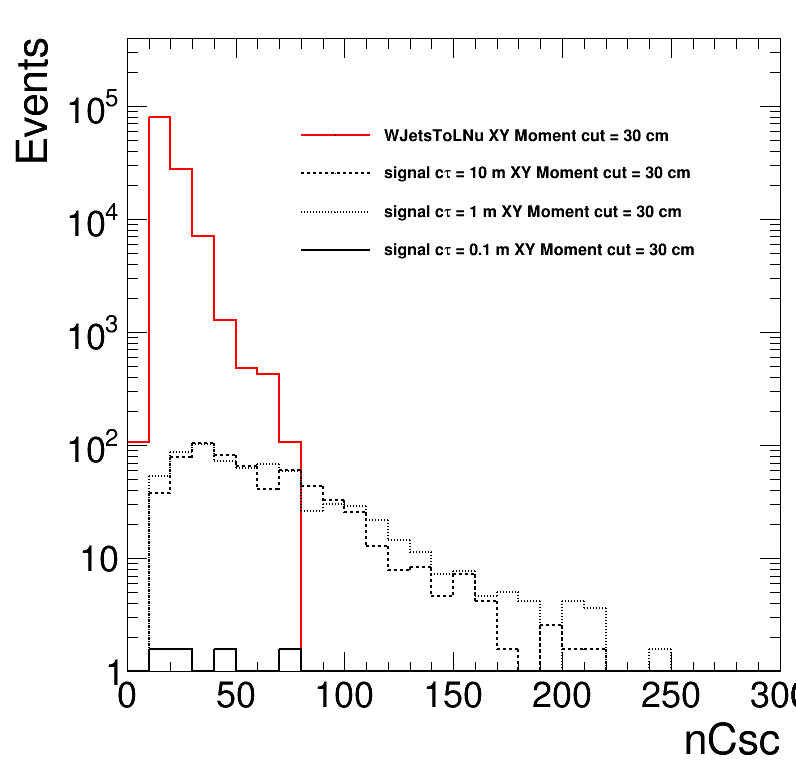

In [39]:
# output_root = rt.TFile("output.root","RECREATE")

start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.36,0.65,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}


cuts = [30]

max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
bkg_nCsc = []
for i,cut in enumerate(cuts):
    for k in tree_bkg.keys():
#         cond = np.logical_and(event_Me1112Veto[k],event_recoJetVeto0p4[k])
        cond = np.logical_not(np.isnan(cscClusterXYSpread[k]))
        cond = np.logical_and(cond, cscClusterXYSpread[k]>cut)
        h[k+str(i)] = create_TH1D(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k][cond])
        if k[:4] == 'bbbb':
            h[k+str(i)].SetLineColor(std_color_list[0])
            if k=='bbbb10m':
                h[k+str(i)].SetLineStyle(2)
            if k=='bbbb1m':
                h[k+str(i)].SetLineStyle(3)
        else:
            h[k+str(i)].SetLineColor(std_color_list[1])
#         h[k+str(i)].SetLineStyle(i+1)
        currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
        if currentMax > max_y:
            max_y = currentMax
            h[k+str(i)].SetMaximum(5*currentMax)
            h[k+str(i)].SetMinimum(1)
        c.cd()
        


#         if k == qcd_key and i == 0:
#             r = h[k+str(i)].Fit('expo', 'LRSQ+', '', 10,100)
#             print(r.Get())
#             h[k+str(i)].GetFunction("expo").SetLineColor(std_color_list[2])
#             h[k+str(i)].GetFunction("expo").SetLineWidth(2)
#             for j in range(300):
#                 bkg_nCsc.append(h[k+str(i)].GetFunction("expo").Eval(j))
#             bkg_nCsc = np.array(bkg_nCsc)
        h[k+str(i)].Draw("same hist")

        
#         output_root.cd()
#         h[k+str(i)].Write(k+"_"+name[i])
    #     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


        leg.AddEntry(h[k+str(i)],legend[k]+" XY Moment cut = "+str(cuts[i])+" cm")

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')
# output_root.Close()

print(time.time()-start_t)




In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.30,0.75,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']

# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# # moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']



max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
for k in tree_bkg.keys():
    cond = np.logical_and(event_recoJetVeto0p4[k], event_Me1112Veto[k])    
    h[k+'event'] = create_TH1D( nCsc[k][cond], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k][cond])
    h[k+'jetveto'] = create_TH1D( nCsc_recoJetVeto0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k])

    if k == 'bbbb':
        h[k+'event'].SetLineColor(std_color_list[0])
        h[k+'jetveto'].SetLineColor(std_color_list[0])

    else:
        h[k+'event'].SetLineColor(std_color_list[1])
        h[k+'jetveto'].SetLineColor(std_color_list[1])

    h[k+'event'].SetLineStyle(0)
    h[k+'jetveto'].SetLineStyle(3)

#     currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
#     if currentMax > max_y:
#         max_y = currentMax
    h[k+'event'].SetMaximum(5*10e6)
    h[k+'event'].SetMinimum(1)

#         h[k+str(i)].SetMinimum(1)
    h[k+'event'].Draw("same hist")
    h[k+'jetveto'].Draw("same hist")
#     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(h[k+'event'],k+" event veto #Delta R = 0.4, Me11 12Veto")
    leg.AddEntry(h[k+'jetveto'],k+" recoJetVeto #Delta R = 0.4, Me11 12Veto")

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# event yield vs. ncsc

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.45,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
h = {}
leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']
var = [nCsc_JetMuonVetoCluster0p4, nCsc_JetMuonVetoCluster0p4_Me1112Veto, 
      nCsc_JetVetoCluster0p4_Me1112Veto,nCsc_JetVetoCluster0p4]
name = ['nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto',
        'nCsc_JetVetoCluster0p4_Me1112Veto','nCsc_JetVetoCluster0p4']
legend = ['jet & muon veto', 'jet & muon veto + ME11/12 veto', 
          'jet veto + ME11/12 veto','jet veto']
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
threshold = np.array(list(range(300)))
for i in range(len(var)):
    event_count = {}
    for k in tree_bkg.keys():
        event_count[k] = []
        for th in threshold:
            event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
    cond = np.logical_not(event_count[k] == 0)
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(threshold[cond], event_count[sig_k][cond],  axis_title=['nCsc', 'Signal Yield'])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 300)
    h[sig_k+str(i)].SetMaximum(10000)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 50000)
    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')
leg.Draw()

c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# significance

0.02547144889831543


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


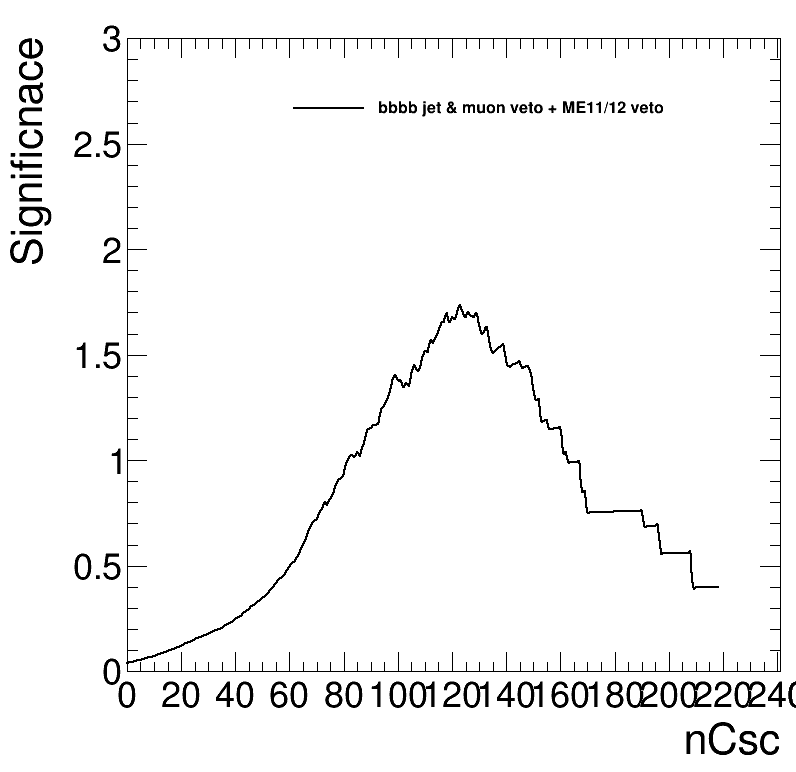

In [91]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.35,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']
var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto,]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
legend = [ 'jet & muon veto + ME11/12 veto',]

bkg_k = 'WJetsToLNu'
sig_k = 'bbbb'
br = 0.1

threshold = list(range(300))
threshold = np.array(list(range(300)))
# print(threshold)
for i in range(len(var)):
    event_count = {}
    
    for k in tree_bkg.keys():
        event_count[k] = []
        for th in threshold:
            if k == qcd_key:
                event_count[k].append(np.sum(bkg_nCsc[th:]))
#                 print(th,np.sum(bkg_nCsc[th:]))
            else:
                event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
        if k == sig_k:
            event_count[k] = event_count[k]*br
    sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = event_count[sig_k]>0
    sig = sig[cond]
    ncsc = threshold[cond]
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(ncsc, sig,  axis_title=['nCsc', 'Significnace'])
    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 300)
    h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 3)


    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')




leg.Draw()
# c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# DBSCAN

In [ ]:
allclusters = {}
cluster0 = {}
for k,v in tree_bkg.items():
    allclusters[k] = []
    cluster0[k] = []
    for i in range(len(cscX[k])):
        data_segments = np.dstack((cscX[k][i], cscY[k][i], cscZ[k][i]))
        db = skc.DBSCAN(eps=200, min_samples=10).fit(data_segments)
        dblabels = db.labels_
        print(set(dblabels))
        unique_db, counts_db = np.unique(dblabels, return_counts=True)
        print(dict(zip(unique_db, counts_db)))

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_db = len(set(dblabels)) - (1 if -1 in dblabels else 0)
        allclusters[k].append(n_clusters_db)
        n_noise_db = list(dblabels).count(-1)
        print(n_noise_db)

# Time response in rechit cut

# Time response in ECAL energy bins

# Time response in t_gen